In [21]:
from time import time
import keras.backend as K
from keras.initializers import VarianceScaling
import pandas as pd
import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.ensemble import RandomTreesEmbedding
from scipy.sparse import csr_matrix
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.preprocessing import RobustScaler, PowerTransformer

In [2]:
df=pd.read_csv('data.csv',index_col='id')

In [3]:
df.head()

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
id,,,,,,,,,,,,,,,,,,,,,
0,-0.389420,-0.912791,0.648951,0.589045,-0.830817,0.733624,2.258560,2,13,14,...,-0.478412,-0.757002,-0.763635,-1.090369,1.142641,-0.884274,1.137896,1.309073,1.463002,0.813527
1,-0.689249,-0.453954,0.654175,0.995248,-1.653020,0.863810,-0.090651,2,3,6,...,-0.428791,-0.089908,-1.784204,-0.839474,0.459685,1.759412,-0.275422,-0.852168,0.562457,-2.680541
2,0.809079,0.324568,-1.170602,-0.624491,0.105448,0.783948,1.988301,5,11,5,...,-0.413534,-1.602377,1.190984,3.267116,-0.088322,-2.168635,-0.974989,1.335763,-1.110655,-3.630723
3,-0.500923,0.229049,0.264109,0.231520,0.415012,-1.221269,0.138850,6,2,13,...,0.619283,1.287801,0.532837,1.036631,-2.041828,1.440490,-1.900191,-0.630771,-0.050641,0.238333
4,-0.671268,-1.039533,-0.270155,-1.830264,-0.290108,-1.852809,0.781898,8,7,5,...,-1.628830,-0.434948,0.322505,0.284326,-2.438365,1.473930,-1.044684,1.602686,-0.405263,-1.987263


## Normalize data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98000 entries, 0 to 97999
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f_00    98000 non-null  float64
 1   f_01    98000 non-null  float64
 2   f_02    98000 non-null  float64
 3   f_03    98000 non-null  float64
 4   f_04    98000 non-null  float64
 5   f_05    98000 non-null  float64
 6   f_06    98000 non-null  float64
 7   f_07    98000 non-null  int64  
 8   f_08    98000 non-null  int64  
 9   f_09    98000 non-null  int64  
 10  f_10    98000 non-null  int64  
 11  f_11    98000 non-null  int64  
 12  f_12    98000 non-null  int64  
 13  f_13    98000 non-null  int64  
 14  f_14    98000 non-null  float64
 15  f_15    98000 non-null  float64
 16  f_16    98000 non-null  float64
 17  f_17    98000 non-null  float64
 18  f_18    98000 non-null  float64
 19  f_19    98000 non-null  float64
 20  f_20    98000 non-null  float64
 21  f_21    98000 non-null  float64
 22

In [5]:
transformer = RobustScaler().fit(df)
df = transformer.transform(df)

In [6]:
power = PowerTransformer().fit(df)
df = pd.DataFrame(power.transform(df))

In [7]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,-0.389227,-0.917639,0.647958,0.590737,-0.824837,0.734694,2.259242,-1.033497,1.407376,1.076834,...,-0.472895,-0.753902,-0.763123,-0.707704,0.911425,-0.678993,0.768510,0.960439,1.043167,0.692866
1,-0.688363,-0.458621,0.653191,0.995389,-1.644049,0.864898,-0.085596,-1.033497,-0.922377,-0.198131,...,-0.423562,-0.088141,-1.777640,-0.535662,0.453245,1.031821,-0.118652,-0.551262,0.367902,-1.635096
2,0.805716,0.319426,-1.166998,-0.622397,0.108386,0.785023,1.990353,0.013448,1.033965,-0.439612,...,-0.408392,-1.598661,1.194351,2.203942,0.086177,-1.518865,-0.568497,0.979032,-0.926147,-2.297124
3,-0.500465,0.224026,0.262743,0.234059,0.417056,-1.218795,0.144463,0.294264,-1.240713,0.957816,...,0.620290,1.283818,0.532909,0.731578,-1.217686,0.826754,-1.172432,-0.395774,-0.099899,0.324430
4,-0.670421,-1.044478,-0.270789,-1.833392,-0.285943,-1.849318,0.787663,0.779194,0.179779,-0.439612,...,-1.615002,-0.432379,0.321957,0.227623,-1.481688,0.848269,-0.613662,1.164903,-0.374124,-1.158148


In [8]:
df.astype('float16').dtypes

0     float16
1     float16
2     float16
3     float16
4     float16
5     float16
6     float16
7     float16
8     float16
9     float16
10    float16
11    float16
12    float16
13    float16
14    float16
15    float16
16    float16
17    float16
18    float16
19    float16
20    float16
21    float16
22    float16
23    float16
24    float16
25    float16
26    float16
27    float16
28    float16
dtype: object

In [11]:
'''intcol=['f_07', 'f_08', 'f_09', 'f_10', 'f_11', 'f_12', 'f_13']
floatcol=[]
allcol=df.columns.tolist()
for i in allcol:
    if not (i in intcol):
        floatcol.append(i)
tonewtypecol = dict.fromkeys(intcol, 'int8')
tofloat16 dict.fromkeys(floatcol, 'float16')
tonewtypecol.update(tofloat16)
df.astype(tonewtypecol).dtypes
print(tonewtypecol)'''

"intcol=['f_07', 'f_08', 'f_09', 'f_10', 'f_11', 'f_12', 'f_13']\nfloatcol=[]\nallcol=df.columns.tolist()\nfor i in allcol:\n    if not (i in intcol):\n        floatcol.append(i)\ntonewtypecol = dict.fromkeys(intcol, 'int8')\ntofloat16 dict.fromkeys(floatcol, 'float16')\ntonewtypecol.update(tofloat16)\ndf.astype(tonewtypecol).dtypes\nprint(tonewtypecol)"

In [12]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,-0.389227,-0.917639,0.647958,0.590737,-0.824837,0.734694,2.259242,-1.033497,1.407376,1.076834,...,-0.472895,-0.753902,-0.763123,-0.707704,0.911425,-0.678993,0.768510,0.960439,1.043167,0.692866
1,-0.688363,-0.458621,0.653191,0.995389,-1.644049,0.864898,-0.085596,-1.033497,-0.922377,-0.198131,...,-0.423562,-0.088141,-1.777640,-0.535662,0.453245,1.031821,-0.118652,-0.551262,0.367902,-1.635096
2,0.805716,0.319426,-1.166998,-0.622397,0.108386,0.785023,1.990353,0.013448,1.033965,-0.439612,...,-0.408392,-1.598661,1.194351,2.203942,0.086177,-1.518865,-0.568497,0.979032,-0.926147,-2.297124
3,-0.500465,0.224026,0.262743,0.234059,0.417056,-1.218795,0.144463,0.294264,-1.240713,0.957816,...,0.620290,1.283818,0.532909,0.731578,-1.217686,0.826754,-1.172432,-0.395774,-0.099899,0.324430
4,-0.670421,-1.044478,-0.270789,-1.833392,-0.285943,-1.849318,0.787663,0.779194,0.179779,-0.439612,...,-1.615002,-0.432379,0.321957,0.227623,-1.481688,0.848269,-0.613662,1.164903,-0.374124,-1.158148


<AxesSubplot:>

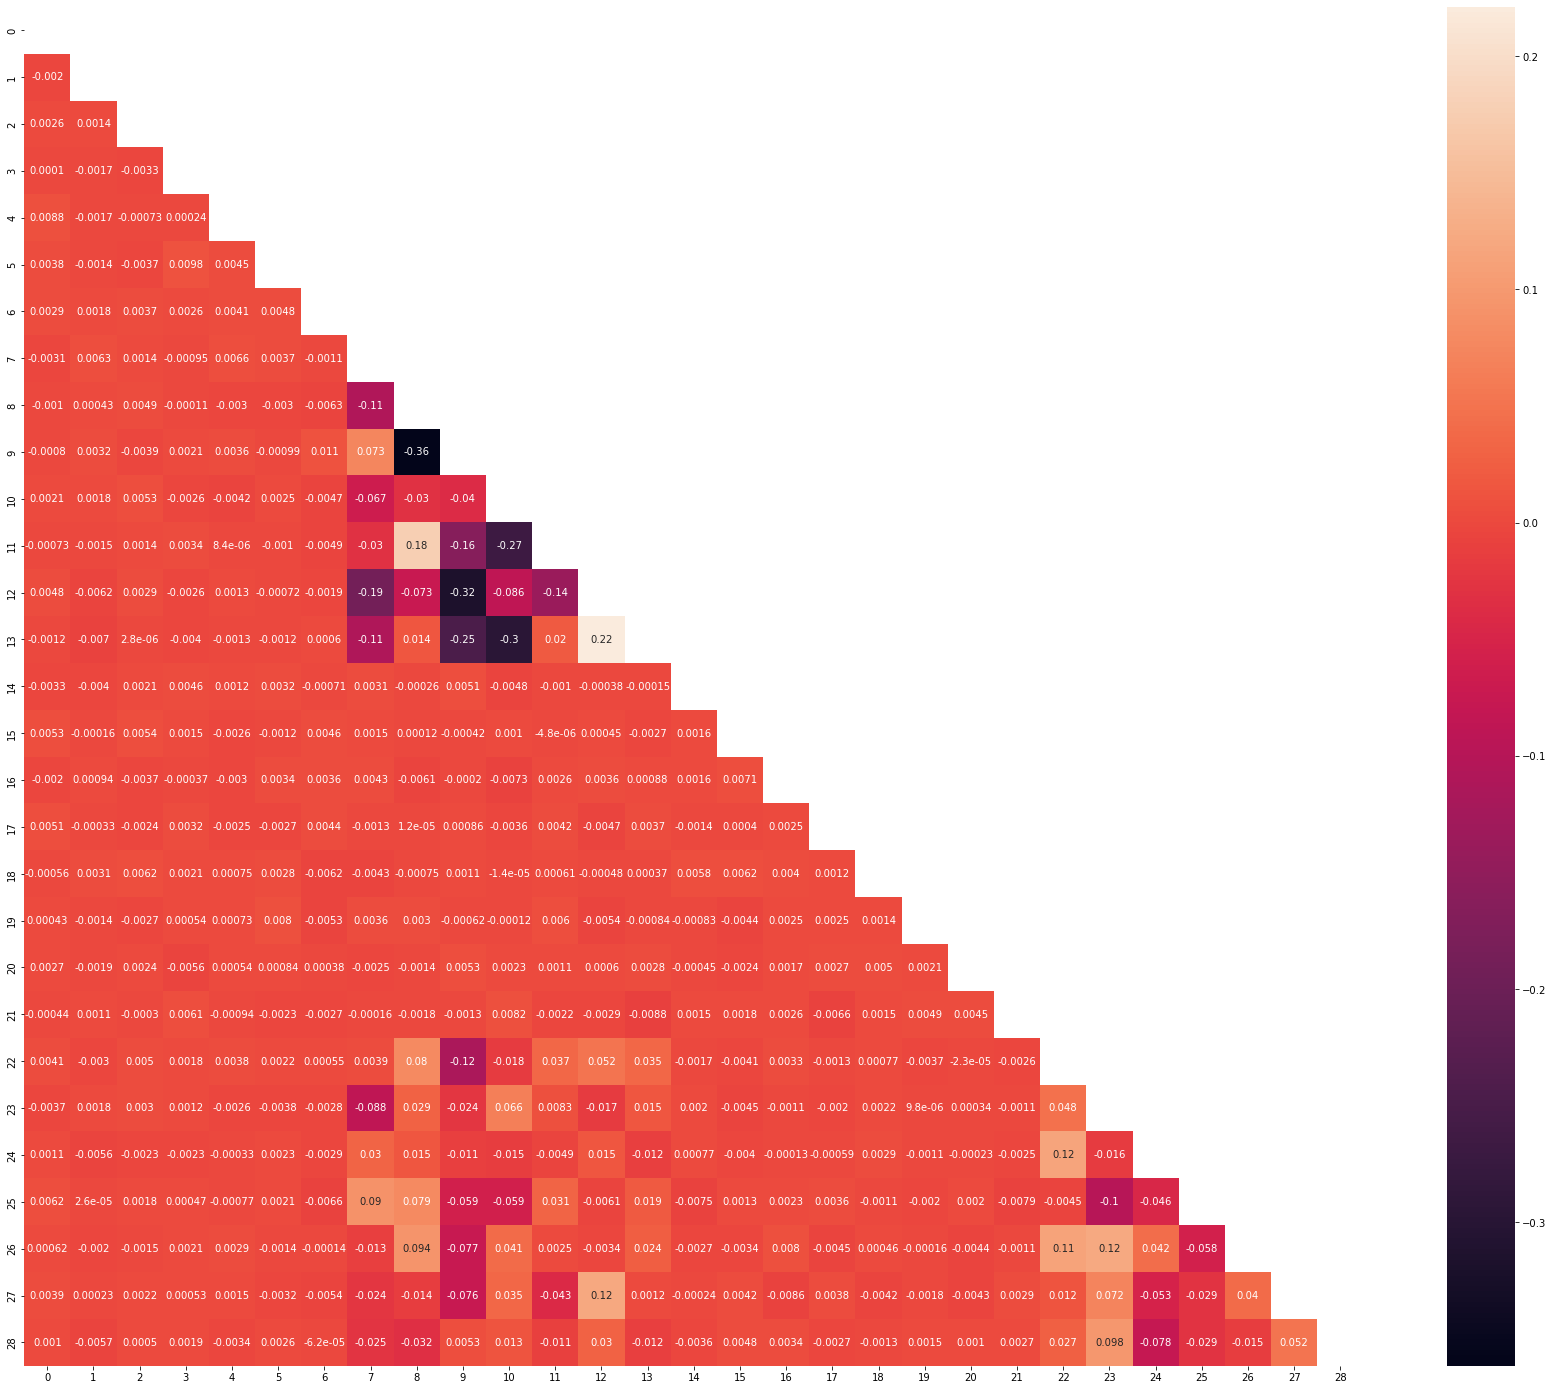

In [13]:
# Correlation between different variables
corr = df.corr()
f, ax = plt.subplots(figsize=(30, 25))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, mask=mask)

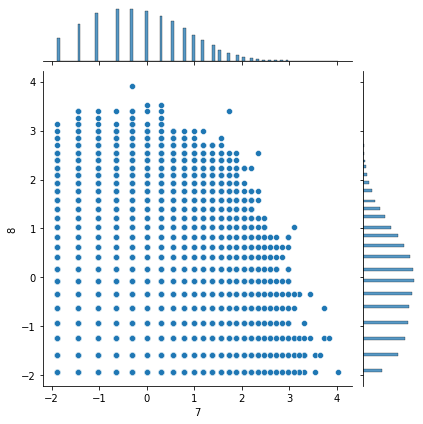

In [14]:
sns.jointplot(data=df, x=7, y=8)

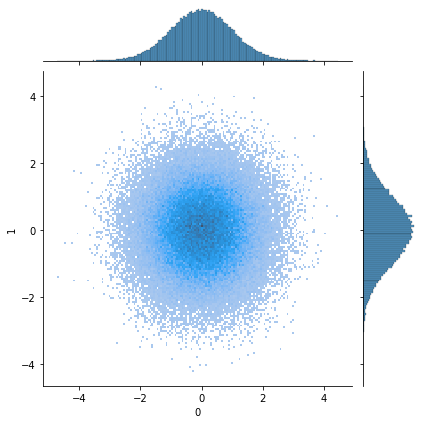

In [15]:
sns.jointplot(data=df, x=0, y=1,kind='hist')

## Train models

#### 1. K-means
* 7-0.23783

In [16]:
clusters_k_means = KMeans(n_clusters = 7).fit_predict(df)

#### 2. Gaussian Mixture
* 7-0.49526(0.51178)
* 8-0.46520
* 9-0.45083

In [17]:
clusters_mixture = GaussianMixture(n_components = 7).fit_predict(df)

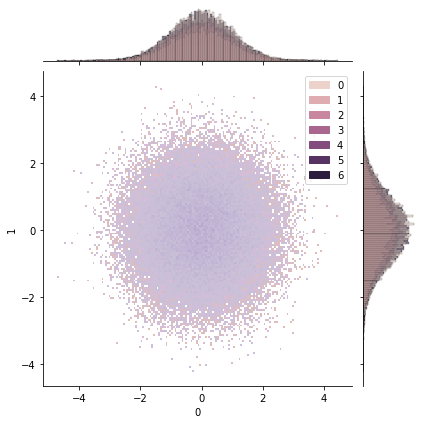

In [18]:
sns.jointplot(data=df, x=0, y=1, hue=clusters_mixture, kind='hist')

#### 3. BayesianGaussianMixture
* 7-0.58122

In [19]:
clusters_bmixture = BayesianGaussianMixture(n_components = 7, covariance_type = 'full', max_iter = 500, 
                                  init_params = 'kmeans', random_state = 42, verbose = 1).fit(df)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
Initialization converged: True


In [20]:
clusters_bmixture = clusters_bmixture.predict(df)

#### 4. Mean-shift

In [ ]:
for i in range(10):
    for j in range(10):
        bandwidth = estimate_bandwidth(df, quantile=0.1*(i+1), n_samples=300*(j+1))
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        ms.fit(df)
        labels = ms.labels_
        n_clusters_ = len(np.unique(labels))
        print("number of estimated clusters : %d" % n_clusters_, end=' ')
        print('quantile'% quantile, end=' ')
        print('n_samples'% n_samples)

#### 4. Random Forest

In [55]:
random_trees = RandomTreesEmbedding(
   n_estimators=500, random_state=42, max_depth=4).fit(df)
X_sparse_embedding = random_trees.transform(df)
Randtree = pd.DataFrame(X_sparse_embedding.toarray())

MemoryError: Unable to allocate 187. MiB for an array with shape (49000000,) and data type int32

In [ ]:
Randtree.astype('int8').dtypes

In [50]:
Randtree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98000 entries, 0 to 97999
Columns: 7241 entries, 0 to 7240
dtypes: float64(7241)
memory usage: 5.3 GB


In [49]:
Randtree.to_csv('Randtree.csv')

In [46]:
clusters_k_means = KMeans(n_clusters = 7).fit_predict(Randtree)

MemoryError: Unable to allocate 1.08 GiB for an array with shape (20000, 7241) and data type float64

In [47]:
clusters_bmixture = BayesianGaussianMixture(n_components = 7, covariance_type = 'full', max_iter = 500, 
                                  init_params = 'kmeans', random_state = 42, verbose = 1).fit(Randtree)

MemoryError: Unable to allocate 5.29 GiB for an array with shape (7241, 98000) and data type float64

#### 5. NN

In [ ]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.        
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)
# Initialize cluster centers using k-means.
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

## Submission

In [148]:
submission = pd.read_csv("sample_submission.csv")
submission["Predicted"] = clusters_k_means
submission.to_csv('submission.csv', index=False)